# 목차
1. [Variables](#variables)
2. [Packages](#packages)
3. [Check Data](#check-data)
4. [Preprocessing](#preprocessing)
5. [Modeling](#Modeling)
6. [Submission](#submission)

# variables

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

# packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA

from scipy.stats import randint, uniform

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.metrics import mean_squared_error

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


# check data

In [2]:
data = pd.read_csv('./data/train.csv', index_col = 'id')
# data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
display(data.head())
print(data.info())

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   price          15035 non-null  float64
 2   bedrooms       15035 non-null  int64  
 3   bathrooms      15035 non-null  float64
 4   sqft_living    15035 non-null  int64  
 5   sqft_lot       15035 non-null  int64  
 6   floors         15035 non-null  float64
 7   waterfront     15035 non-null  int64  
 8   view           15035 non-null  int64  
 9   condition      15035 non-null  int64  
 10  grade          15035 non-null  int64  
 11  sqft_above     15035 non-null  int64  
 12  sqft_basement  15035 non-null  int64  
 13  yr_built       15035 non-null  int64  
 14  yr_renovated   15035 non-null  int64  
 15  zipcode        15035 non-null  int64  
 16  lat            15035 non-null  float64
 17  long           15035 non-null  float64
 18  sqft_l

In [3]:
print(data['date'].min(), data['date'].max())

201405 201505


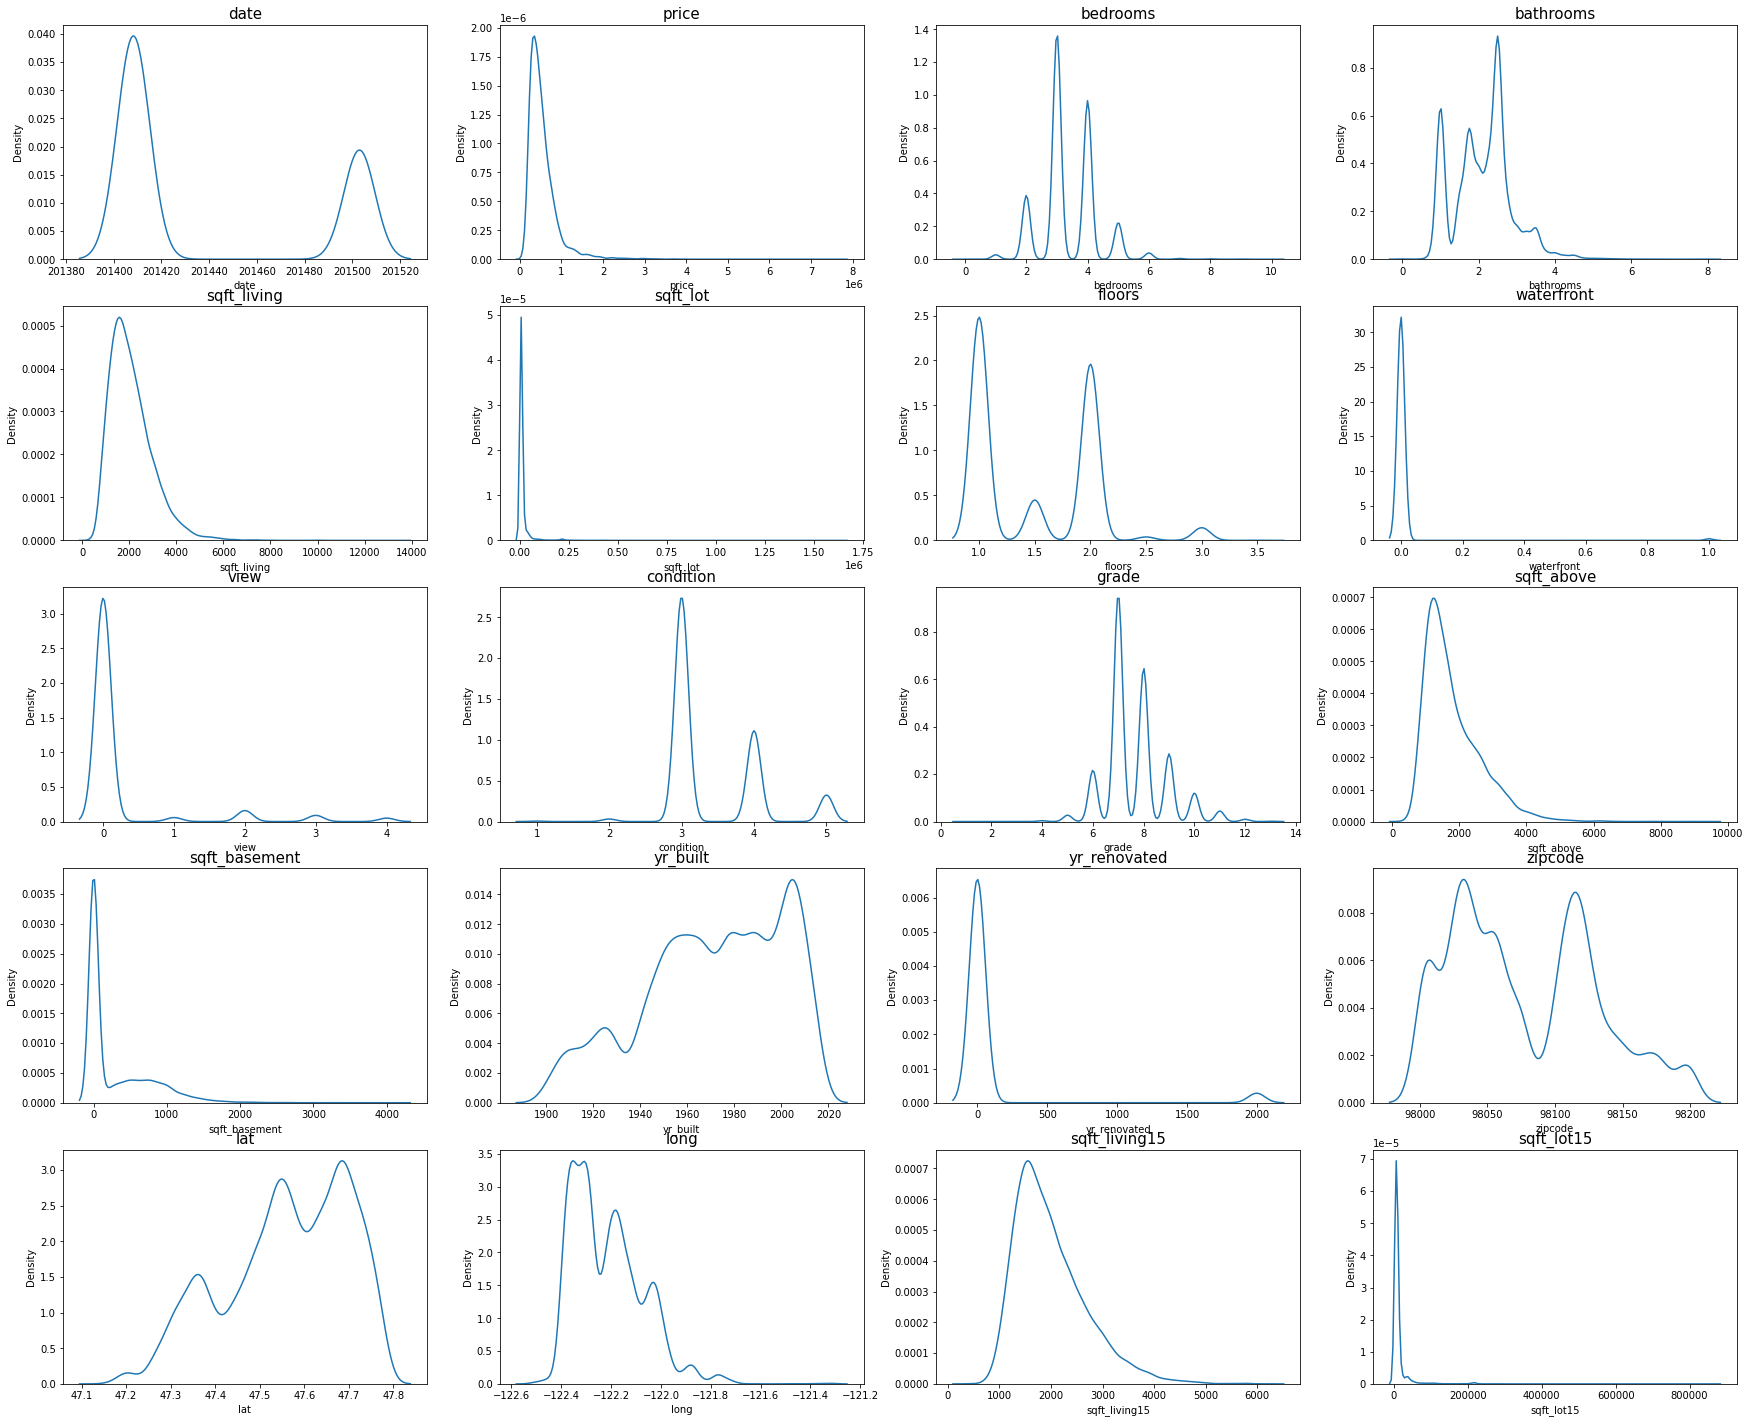

In [4]:
fig, ax = plt.subplots(5, 4, figsize = (30, 25))

columns = data.columns
count = 0
for row in range(5):
    for col in range(4):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
plt.show()

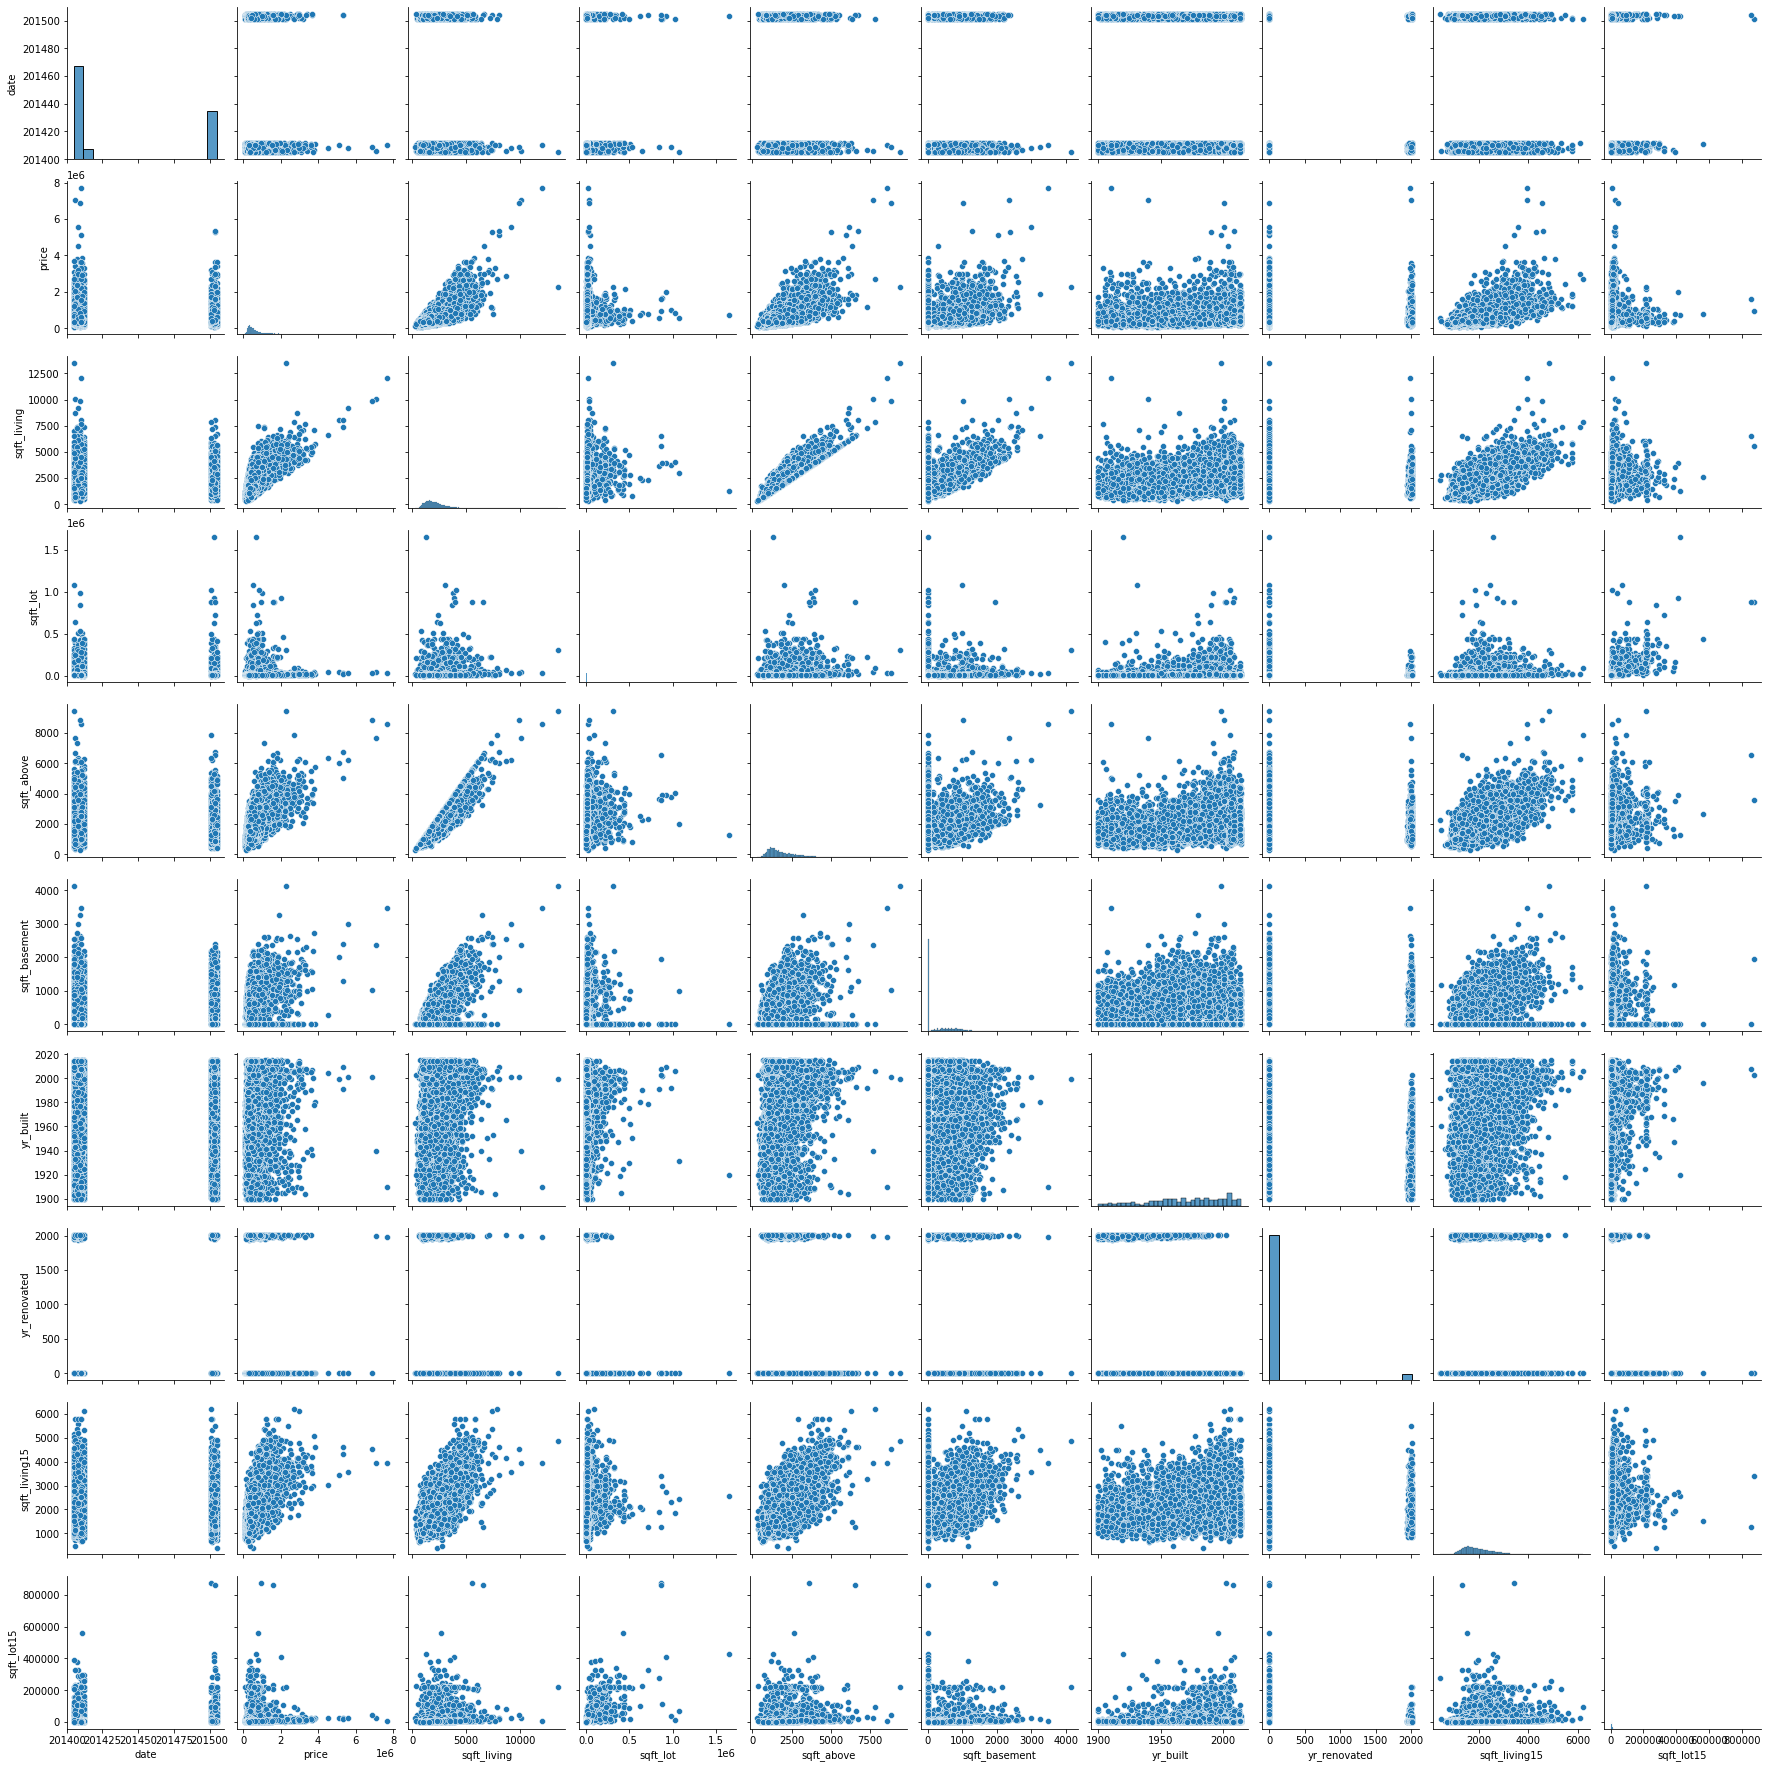

In [5]:
scatter_cols = [
    'date', 'price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
    'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15'
]
sns.pairplot(data[scatter_cols])
plt.show()

In [6]:
print(data['yr_renovated'].describe())

count    15035.000000
mean        83.798936
std        400.398498
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64


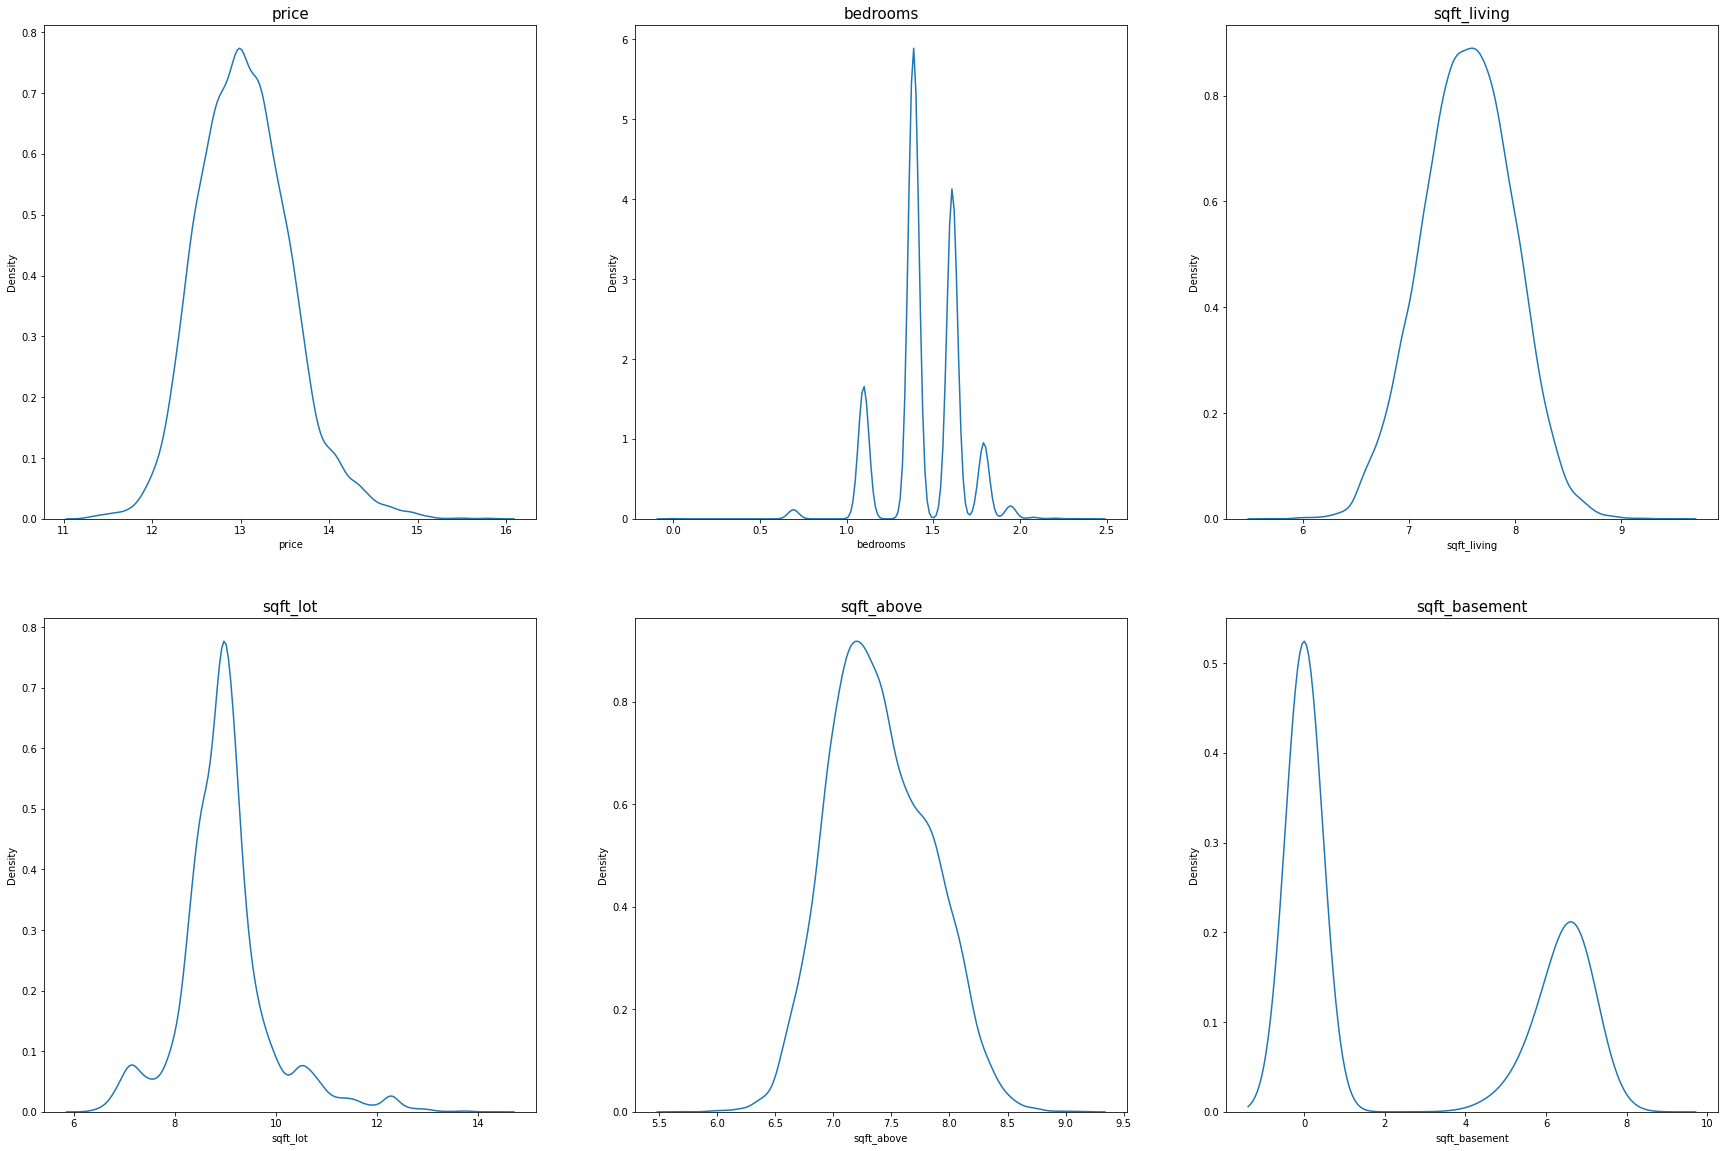

In [7]:
skew_columns = ['price', 'bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

fig, ax = plt.subplots(2, 3, figsize = (30, 20))

count = 0
for row in range(2):
    for col in range(3):
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1
plt.show()

In [8]:
print(data.describe())

                date         price      bedrooms     bathrooms   sqft_living  \
count   15035.000000  15035.000000  15035.000000  15035.000000  15035.000000   
mean   201438.545993     13.048122      1.452912      2.115065      7.552362   
std        44.252050      0.527471      0.210784      0.767519      0.425656   
min    201405.000000     11.264477      0.000000      0.000000      5.673323   
25%    201407.000000     12.682310      1.386294      1.750000      7.266129   
50%    201410.000000     13.017005      1.386294      2.250000      7.555382   
75%    201502.000000     13.377007      1.609438      2.500000      7.848153   
max    201505.000000     15.856731      2.397895      8.000000      9.513477   

           sqft_lot        floors    waterfront          view     condition  \
count  15035.000000  15035.000000  15035.000000  15035.000000  15035.000000   
mean       8.992803      1.498071      0.007117      0.234253      3.406651   
std        0.905809      0.538522      0.0

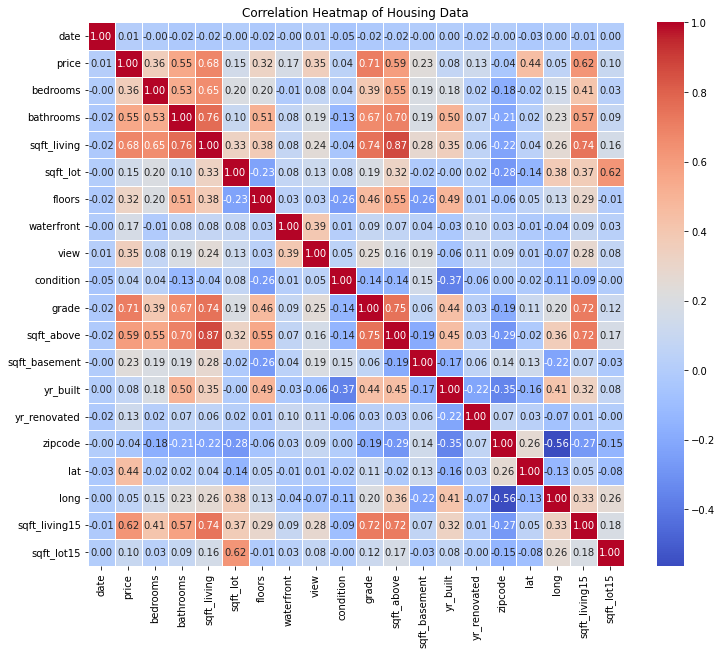

In [9]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Housing Data")
plt.show()

In [10]:
X = data.drop('price', axis = 1)
y = data['price']

random_state = 526

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = random_state)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(12028, 19) (3007, 19)
(12028,) (3007,)


# preprocessing

## scaling

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 변수 선택

In [12]:
selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

## pca

In [13]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

# Modeling

## stack_reg again

In [14]:
# gboost_best_params = {
#     'learning_rate': 0.025670,
#     'max_depth': 9,
#     'max_features': 'log2',
#     'min_samples_leaf': 2,
#     'min_samples_split': 2,
#     'n_estimators': 256,
#     'subsample': 0.742265
# }

# xgboost_best_params = {
#     'colsample_bytree': 0.866721,
#     'gamma': 0.043420,
#     'learning_rate': 0.066143,
#     'max_depth': 9,
#     'n_estimators': 121,
#     'subsample': 0.727895
# }

# lightgbm_best_params = {
#     'colsample_bytree': 0.964985,
#     'learning_rate': 0.043732,
#     'max_depth': 9,
#     'n_estimators': 346,
#     'reg_alpha': 0.077336,
#     'reg_lambda': 0.158151,
#     'subsample': 0.850568,
# }

# rdforest_best_params = {
#     'max_depth': 14.0,
#     'max_features': 'auto',
#     'min_samples_leaf': 2,
#     'min_samples_split': 12,
#     'n_estimators': 934,
# }

# 시간이 오래 걸려 생략
# gboost = GradientBoostingRegressor(**gboost_best_params, random_state=random_state)
# xgboost = XGBRegressor(**xgboost_best_params, random_state=random_state)
# lightgbm = LGBMRegressor(**lightgbm_best_params, random_state=random_state)
# rdforest = RandomForestRegressor(**rdforest_best_params, random_state=random_state)

# models = [
#     ('gboost', gboost),
#     ('xgboost', xgboost),
#     ('lightgbm', lightgbm),
#     ('rdforest', rdforest)
# ]

# model = StackingRegressor(models, final_estimator = lightgbm)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_train)
# print(np.sqrt(mean_squared_error(np.expm1(y_pred), np.expm1(y_test))))

## lightgbm
### RandomizedSearchCV

In [15]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(3, 30),
    'subsample': uniform(0.6, 0.4),  # 0.6부터 1.0까지의 값 중에서 랜덤 샘플링
    'colsample_bytree': uniform(0.6, 0.4),  # 0.6부터 1.0까지의 값 중에서 랜덤 샘플링
    'reg_alpha': uniform(0, 0.2),
    'reg_lambda': uniform(0, 0.2)
}

lightgbm = LGBMRegressor(random_state=random_state)
model = RandomizedSearchCV(estimator = lightgbm,
                          param_distributions = param_dist,
                          cv = 5,
                          scoring = 'neg_mean_squared_error',
                          n_jobs = -1,
                          random_state = random_state)
model.fit(X_train, y_train)
best_model = model.best_estimator_
print(best_model)

y_pred = best_model.predict(X_test)

print(np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

109503.36307035982


## Deep learning

In [16]:
# def create_model(input_shape,
#                  optimizer='adam',
#                  activation='relu',
#                  neurons=64, layers=3, dropout_rate=0.2):
#     model = Sequential()
#     model.add(Dense(neurons, activation=activation, input_shape=(input_shape,)))
#     model.add(Dropout(dropout_rate))
#     for _ in range(layers - 1):
#         model.add(Dense(neurons, activation=activation))
#         model.add(Dropout(dropout_rate))
#     model.add(Dense(1))  # 회귀 모델이므로 출력 레이어는 하나의 노드만 사용합니다.
#     model.compile(optimizer=optimizer, loss='mean_squared_error')
#     return model

# param_dist = {
#     'optimizer': ['adam', 'sgd', 'rmsprop'],
#     'activation': ['relu', 'tanh', 'sigmoid'],
#     'neurons': [32, 64, 128],
#     'layers': [2, 3, 4],  # 레이어 수를 추가하여 탐색
#     'dropout_rate': [0.0, 0.2, 0.4],  # 드롭아웃 비율 추가
#     'input_shape': [X_train_selected.shape[1]]
# }

# model = KerasRegressor(build_fn=create_model, epochs=10, batch_size=32, verbose=0)

# random_search = RandomizedSearchCV(estimator=model,
#                                    param_distributions=param_dist,
#                                    n_iter=10,
#                                    cv=3,
#                                    scoring='neg_mean_squared_error',
#                                    random_state=random_state)

# random_search.fit(X_train_selected, y_train)
# best_model = random_search.best_estimator_

# y_pred = best_model.predict(X_test_selected)
# print(np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))))

# submission

In [17]:
def preprocessing(data):
    data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
    
    skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

    for c in skew_columns:
        data[c] = np.log1p(data[c].values)
    
#     data = scaler.transform(data)
#     data = selector.transform(data)
#     data = pca.transform(data)
    return data

In [18]:
test = pd.read_csv('./data/test.csv', index_col = 'id')
test = preprocessing(test)

In [19]:
pred = best_model.predict(test)
pred = np.expm1(pred)
print(pred)

[ 496348.53819237  491253.23631292 1390758.45714464 ...  473976.47159646
  327557.2123566   446843.1822517 ]


In [20]:
submission = pd.read_csv('./data/submission.csv')
submission.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [23]:
print(len(submission))

6468


In [22]:
submission['price'] = pred
submission.to_csv('./data/submission_lightgbm_rdsearch.csv', index=False)

딥러닝 모델은 스케일링, 변수선택을 했을 때 가장 좋은 결과를 보였지만, lightgbm은 일부 변수를 로그변환한 모델의 성능이 가장 좋았음. tree 기반의 알고리즘이기 때문으로 보임.<br>
StackingRegressor보다 RandomizedSearchCV의 성능이 더 좋음. RandomizedSearchCV는 교차 검증을 사용해서 약간의 성능차이가 있을 수 있다. 본 실험에서는 RandomizedSearchCV를 사용하였다.<br>

캐글 private score: 114102.62179  
캐글: https://www.kaggle.com/code/wjdgml0526/notebook24ddf2fa48/notebook